# Deteksi Objek Masker Wajah dengan YOLOv8

Proyek ini adalah implementasi *pipeline machine learning* untuk tugas **Deteksi Objek** (*Object Detection*).

Tujuan utamanya adalah membangun dan melatih sebuah model *deep learning* untuk mendeteksi serta mengklasifikasikan penggunaan masker wajah pada gambar.

---

**Studi Kasus & Model:**
* **Studi Kasus**: Mendeteksi penggunaan masker wajah.
* **Model**: **YOLOv8n** (versi *nano*), dipilih karena ukurannya kecil dan kecepatannya tinggi, sehingga cocok untuk *transfer learning*.
* **Tugas**: *Transfer Learning*, yaitu melatih ulang model YOLOv8 yang sudah ada untuk menjadi spesialis dalam mendeteksi masker.

**Kelas Target:**
Model AI akan dilatih untuk mengenali tiga kondisi spesifik:
1.  `with_mask`: Orang yang memakai masker dengan benar.
2.  `without_mask`: Orang yang tidak memakai masker.
3.  `mask_weared_incorrect`: Orang yang memakai masker dengan cara yang salah (misalnya, di bawah hidung atau dagu).

**Dataset:**
Menggunakan dataset publik dari Kaggle ([Face Mask Detection Dataset](https://www.kaggle.com/datasets/andrewmvd/face-mask-detection)) yang berisi ribuan gambar dengan anotasi untuk ketiga kelas tersebut.

Notebook ini akan mencakup keseluruhan proses: mengunduh data, pra-pemrosesan (mengubah format anotasi XML ke YOLO), melatih model, mengevaluasi kinerja, dan menguji model dengan gambar baru.

Link notebook di Google Colab: [Google Colab](https://colab.research.google.com/drive/1eg0Y1A0JNb3tH-Bj9G16_m4vzb6l_W2I?usp=sharing#scrollTo=weAsAyCCMj-H)

## 1. Instalasi dan Import Library

Langkah pertama adalah menyiapkan semua *library* yang dibutuhkan untuk proyek ini.

* **Instalasi**: Menginstal `ultralytics` (untuk YOLOv8), `kagglehub` (untuk mengunduh dataset), dan `xmltodict` (untuk memproses file anotasi).
* **Import**: Setelah terinstal, *library* tersebut di-`import` agar dapat digunakan dalam kode.

In [ ]:
!pip install "ultralytics>=8.2,<9" xmltodict==0.13.0 tqdm==4.66.4 scikit-learn==1.5.2 numpy pandas matplotlib opencv-python pillow torch
!pip -q install kagglehub>=0.2.5

In [ ]:
import os
import sys
import re
import csv
import io
import json
import random
import shutil
import platform
import subprocess
import xml.etree.ElementTree as ET
from glob import glob
from pathlib import Path
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from PIL import Image

import torch
from sklearn.model_selection import train_test_split
from ultralytics import YOLO
import kagglehub
from google.colab import files

import ultralytics
ultralytics.checks()

Ultralytics 8.3.227 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 40.5/112.6 GB disk)


Berikut adalah penjelasan untuk *library* utama yang digunakan:

* **numpy**: Digunakan untuk komputasi numerik. Berperan dalam mengelola data gambar sebagai *array* yang efisien.
* **pandas**: Digunakan untuk analisis dan manipulasi data terstruktur. Dalam proyek ini, dipakai untuk membaca hasil pelatihan (file `results.csv`).
* **matplotlib**: *Library* untuk visualisasi data, seperti membuat plot, diagram, dan menampilkan gambar.
* **cv2 (OpenCV)**: *Library* utama untuk *Computer Vision*. Digunakan untuk membaca gambar dan menggambar *bounding box*.
* **torch (PyTorch)**: *Framework deep learning* yang menjadi basis `ultralytics`. Menangani kalkulasi kompleks dan pelatihan model pada GPU.
* **ultralytics**: *Library* resmi untuk YOLOv8. Menyederhanakan proses pelatihan, validasi, dan inferensi model deteksi objek.

## 2. Pengaturan Awal (Konstanta dan Direktori)

Sebelum mengolah data, perlu dilakukan pengaturan variabel penting untuk konfigurasi proyek.

* **Seed untuk Reproducibility**: `SEED = 42` ditetapkan untuk *library* seperti `random`, `numpy`, dan `torch`. Ini memastikan bahwa setiap proses yang melibatkan keacakan (misalnya, pembagian data, inisialisasi model) akan menghasilkan output yang sama setiap kali kode dijalankan, sehingga eksperimen bersifat **reproducible**.
* **Pengaturan Path (Direktori)**: Variabel `ROOT`, `DATASET_DIR`, dan `WORK` didefinisikan untuk mengelola struktur file. `WORK` akan menjadi direktori kerja utama yang menyimpan data terproses dan file yang siap untuk pelatihan YOLO.
* **Definisi Kelas**: Nama-nama kelas target (`with_mask`, `without_mask`, `mask_weared_incorrect`) didefinisikan dalam *list* bernama `CLASSES`. Urutan item dalam *list* ini penting karena menentukan ID numerik untuk setiap kelas (contoh: `with_mask` = 0).

In [ ]:
# Random Seed
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
if torch.cuda.is_available():
    torch.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)

In [ ]:
# Pengaturan Path (Direktori)
ROOT = Path("/content")
DATASET_DIR = ROOT/"face-mask-detection"     # lokasi ekstraksi dataset zip dari Kaggle nantinya
WORK = ROOT/"mask-yolo"                      # direktori kerja YOLO

for sub in ["images",
            "labels",
            "train/images",
            "train/labels",
            "val/images",
            "val/labels",
            "test/images",
            "test/labels"]:
    (WORK/sub).mkdir(parents=True, exist_ok=True)

In [ ]:
CLASSES = [
    "without_mask",
    "with_mask",
    "mask_weared_incorrect"
]

print("Classes:", CLASSES)

Classes: ['without_mask', 'with_mask', 'mask_weared_incorrect'] nc: 3


## 3. Persiapan Dataset (Data Preparation)

Dataset mentah dari Kaggle tidak dapat langsung digunakan untuk melatih YOLOv8 dan memerlukan pemrosesan terlebih dahulu.

Proses **Data Preparation** ini dibagi menjadi beberapa langkah utama:

1.  **Akuisisi Data**: Mengunduh dataset mentah dari Kaggle menggunakan *library* `kagglehub`.
2.  **Pra-pemrosesan & Konversi Format**: Dataset ini menggunakan anotasi format **Pascal VOC (.xml)**, yang tidak kompatibel dengan format **YOLO (.txt)**. Sebuah skrip akan dibuat untuk membaca file `.xml`, mengekstrak koordinat *bounding box* dan nama kelas, lalu mengonversinya ke format `.txt` yang telah dinormalisasi.
3.  **Pemisahan Data (Data Splitting)**: Setelah dikonversi, data akan dibagi menjadi tiga set terpisah menggunakan `sklearn`:
    * **Training Set** (Data Latih): Porsi terbesar data (misal 70%) yang digunakan untuk melatih model.
    * **Validation Set** (Data Validasi): Porsi data (misal 15%) yang digunakan untuk mengevaluasi kinerja model di setiap *epoch* pelatihan.
    * **Test Set** (Data Uji): Porsi data (misal 15%) yang disimpan untuk pengujian akhir model terhadap data baru.
4.  **Konfigurasi Dataset**: Membuat file konfigurasi `data.yaml`. File ini berisi definisi path ke direktori `train/`, `val/`, dan `test/`, serta daftar kelas yang akan digunakan oleh YOLOv8.
5.  **Verifikasi Dataset**: Memeriksa kembali struktur direktori untuk memastikan semua gambar dan anotasi telah diproses dengan benar dan dapat diakses.

### 3.1 Akuisisi Data

Tahap ini akan mengunduh dataset dari Kaggle dan memindahkannya ke direktori kerja kita seperti yang sudah ditetapkan di tahap sebelumnya

In [ ]:
src_path = kagglehub.dataset_download("andrewmvd/face-mask-detection")
src_path = Path(src_path)

if DATASET_DIR.exists():
    shutil.rmtree(DATASET_DIR)
shutil.copytree(src_path, DATASET_DIR)

print("Dataset telah dipindahkan ke: ", DATASET_DIR)

# Verifikasi isi dataset untuk tahap berikutnya: konversi format VOC ke YOLO
ann_files = list((DATASET_DIR / "annotations").glob("*.xml"))
img_files = list((DATASET_DIR / "images").glob("*.*"))

print("Jumlah Annotations:", len(ann_files))
print("Jumlah Gambar:", len(img_files))
print("Sample File XML:", [p.name for p in ann_files[:5]])
print("Sample File IMG:", [p.name for p in img_files[:5]])

Using Colab cache for faster access to the 'face-mask-detection' dataset.
KaggleHub path: /kaggle/input/face-mask-detection
Jumlah Annotations: 853
Jumlah Gambar: 853
Sample File XML: ['maksssksksss8.xml', 'maksssksksss227.xml', 'maksssksksss162.xml', 'maksssksksss303.xml', 'maksssksksss691.xml']
Sample File IMG: ['maksssksksss833.png', 'maksssksksss457.png', 'maksssksksss560.png', 'maksssksksss623.png', 'maksssksksss567.png']


### 3.2 Pra-pemrosesan & Konversi Format

Tujuan dari langkah ini adalah mengonversi anotasi dari format **Pascal VOC (.xml)** ke format **YOLO (.txt)**.

Konversi ini merupakan persyaratan wajib, karena model *pre-trained* YOLOv8 membutuhkan format data input yang spesifik. Tanpa proses ini, dataset yang dimiliki tidak dapat digunakan untuk pelatihan model YOLO.

In [ ]:
ANNOTATIONS_DIR = DATASET_DIR / "annotations"
IMAGES_DIR = DATASET_DIR / "images"

def xml_to_yolo(xmin, ymin, xmax, ymax, image_width, image_height):
    """
    Mengonversi satu bounding box dari format VOC ke format YOLO.
    """
    box_width = xmax - xmin
    box_height = ymax - ymin
    center_x = (xmin + xmax) / 2.0
    center_y = (ymin + ymax) / 2.0

    norm_center_x = center_x / image_width
    norm_center_y = center_y / image_height
    norm_width = box_width / image_width
    norm_height = box_height / image_height

    return norm_center_x, norm_center_y, norm_width, norm_height

usable_image_stems = []
print(f"Memulai konversi anotasi dari: {ANNOTATIONS_DIR}")
for xml_file_path in sorted(glob(str(ANNOTATIONS_DIR / "*.xml"))):
    xml_tree = ET.parse(xml_file_path)
    root = xml_tree.getroot()

    filename_in_xml = root.findtext("filename")
    image_stem = Path(filename_in_xml).stem

    # Validasi path gambar (mendukung .png dan .jpg)
    corresponding_image_path = IMAGES_DIR / f"{image_stem}.png"
    if not corresponding_image_path.exists():
        corresponding_image_path = IMAGES_DIR / f"{image_stem}.jpg"
        if not corresponding_image_path.exists():
            print(f"Peringatan: Melewatkan {image_stem} (file gambar tidak ditemukan)")
            continue

    # Ambil dimensi gambar dari XML
    image_width = int(root.find("size/width").text)
    image_height = int(root.find("size/height").text)

    yolo_format_lines = []

    for obj_element in root.findall("object"):
        class_name = obj_element.findtext("name")
        if class_name not in CLASSES:
            continue

        class_id = CLASSES.index(class_name)

        bbox_element = obj_element.find("bndbox")
        xmin = int(bbox_element.findtext("xmin"))
        ymin = int(bbox_element.findtext("ymin"))
        xmax = int(bbox_element.findtext("xmax"))
        ymax = int(bbox_element.findtext("ymax"))

        # Konversi ke format YOLO
        cx_norm, cy_norm, w_norm, h_norm = xml_to_yolo(
            xmin, ymin, xmax, ymax, image_width, image_height
        )

        # Format string YOLO: "id_kelas center_x center_y width height"
        yolo_format_lines.append(f"{class_id} {cx_norm:.6f} {cy_norm:.6f} {w_norm:.6f} {h_norm:.6f}")

    # Simpan hasil konversi jika ada objek valid
    if yolo_format_lines:
        output_image_path = WORK / "images" / corresponding_image_path.name
        output_image_path.write_bytes(corresponding_image_path.read_bytes())
        output_label_path = WORK / "labels" / f"{image_stem}.txt"
        output_label_path.write_text("\n".join(yolo_format_lines))
        usable_image_stems.append(image_stem)

print(f"Konversi selesai. Total gambar yang akan dipakai: {len(usable_image_stems)}")

Memulai konversi anotasi dari: /content/face-mask-detection/annotations
Konversi selesai. Total gambar yang akan dipakai: 853


### 3.3 Pemisahan Data (Train/Val/Test Split)

Tujuan: Membagi data kita menjadi set train, validation, dan test dengan proporsi kelas yang seimbang (stratified).



In [ ]:
# X adalah daftar nama file gambar dan anotasi kita
X = np.array(usable_image_stems)

# y adalah daftar label (kelas) yang bersesuaian dengan X
y = []

for image_stem in X:
    label_content = (WORK / "labels" / f"{image_stem}.txt").read_text()
    first_class_id = int(label_content.split()[0])
    y.append(first_class_id)

y = np.array(y)

# --- Pembagian Bertingkat (Stratified Split) ---
# 'stratify=y' memastikan proporsi kelas tetap sama di semua set.
# Langkah 1: Pisahkan 70% (train) dan 30% (sementara/tmp)
X_train, X_tmp, y_train, y_tmp = train_test_split(
    X, y, test_size=0.30, random_state=SEED, stratify=y
)

# Langkah 2: Pisahkan 30% (tmp) menjadi 15% (val) dan 15% (test)
X_val, X_test, y_val, y_test = train_test_split(
    X_tmp, y_tmp, test_size=0.50, random_state=SEED, stratify=y_tmp
)

# Hasil: kita memiliki dataset dengan pembagian 70% training, 15% Validasi, dan 15% Testing

def move_files(image_stems_list, split_directory_name):
    """
    Fungsi helper untuk menyalin file (gambar & label)
    dari data pool (WORK) ke folder split tujuannya (cth: WORK/train/...).
    """
    for stem in image_stems_list:

        # Cari ekstensi gambar yang benar (.png atau .jpg)
        for extension in [".png", ".jpg", ".jpeg"]:
            source_image_path = WORK / "images" / f"{stem}{extension}"

            if source_image_path.exists():
                # Tentukan folder tujuan dan salin file gambar
                dest_image_dir = WORK / f"{split_directory_name}/images"
                shutil.copy(source_image_path, dest_image_dir / source_image_path.name)
                break # Hentikan pencarian ekstensi jika sudah ketemu

        # Salin file label .txt yang sesuai
        source_label_path = WORK / "labels" / f"{stem}.txt"
        dest_label_dir = WORK / f"{split_directory_name}/labels"
        shutil.copy(source_label_path, dest_label_dir / source_label_path.name)

move_files(X_train, "train")
move_files(X_val, "val")
move_files(X_test, "test")

print(f"Data berhasil dipisah:")
print(f"Train: {len(X_train)} gambar")
print(f"Val:   {len(X_val)} gambar")
print(f"Test:  {len(X_test)} gambar")

Data berhasil dipisah:
Train: 597 gambar
Val:   128 gambar
Test:  128 gambar


### 3.4 Konfigurasi Dataset

Tujuan: Membuat file konfigurasi .yaml yang memberi tahu YOLO di mana menemukan data dan apa nama kelasnya untuk proses training nantinya.


In [ ]:
data_yaml_content = f"""
path: {WORK}
train: train/images
val: val/images
test: test/images

nc: {len(CLASSES)}
names: {json.dumps(CLASSES)}
"""

# simpan ke dalam file data.yaml di folder kerja kita
(WORK / "data.yaml").write_text(data_yaml_content)

149

### 3.5 Periksa Isi Dataset

In [ ]:
def check_file_pairs(split_name: str):
    """
    Menghitung jumlah gambar dan label yang cocok
    di dalam direktori split yang diberikan (cth: "train").
    """
    image_paths = list((WORK / split_name / "images").glob("*.*"))
    corresponding_label_paths = [
        WORK / split_name / "labels" / (img_path.stem + ".txt")
        for img_path in image_paths
    ]
    matching_label_count = sum(int(label_path.exists()) for label_path in corresponding_label_paths)
    return len(image_paths), matching_label_count

print("\nMemeriksa pasangan file (Gambar vs Label):")

# Loop melalui setiap set data dan jalankan pengecekan
for split_set in ["train", "val", "test"]:
    image_count, label_count = check_file_pairs(split_set)

    print(f"Set '{split_set}':")
    print(f"  -> Gambar ditemukan: {image_count}")
    print(f"  -> Label cocok:    {label_count}")

    # Beri peringatan jika ada ketidakcocokan
    if image_count != label_count:
        print(f"  **PERINGATAN: Jumlah gambar dan label tidak cocok di '{split_set}'!**")


Memeriksa pasangan file (Gambar vs Label):
Set 'train':
  -> Gambar ditemukan: 597
  -> Label cocok:    597
Set 'val':
  -> Gambar ditemukan: 128
  -> Label cocok:    128
Set 'test':
  -> Gambar ditemukan: 128
  -> Label cocok:    128


## 5. EDA (Exploratory Data Anaysis)

Sebelum melatih, kita dapat mencoba mengeksplorasi data kita, menemukan informasi penting tentang dataset yang mungkin dapat mempengaruhi hasil dari model dan proses belajarnya. Sebagai contoh, kita akan melakukan:

* **Analisis Distribusi Kelas**:
    * Kita menghitung jumlah total *bounding box* untuk setiap kelas (`with_mask`, `without_mask`, `mask_weared_incorrect`).
    * Ini penting untuk memeriksa **imbalance** dataset (apakah ada kelas yang jumlahnya terlalu sedikit).
    * Hasilnya kita plot dalam diagram batang agar mudah terlihat.

* **Tampilan Anotasi Visual**:
    * Kita membuat fungsi `visualize_yolo_annotation` untuk menggambar *bounding box* pada gambar berdasarkan file label `.txt`-nya.
    * Jika kotak dan labelnya pas, kita tahu data kita valid dan siap dilatih.

Distribusi kelas - train:
without_mask 529
with_mask 2299
mask_weared_incorrect 90


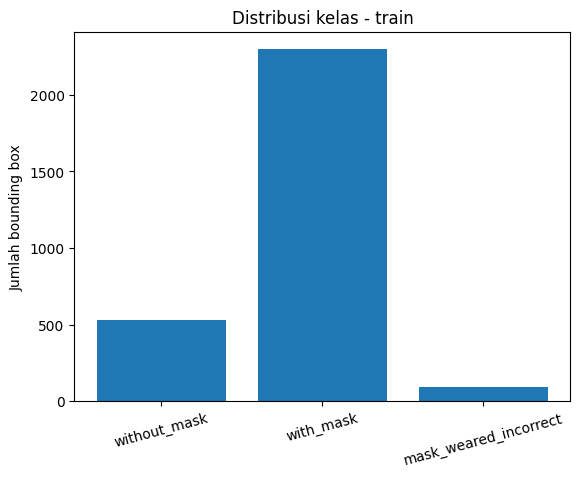

In [ ]:
# Hitung distribusi kelas dari file label YOLO
def calculate_class_distribution(label_directory):
    class_counter = Counter()
    for label_file in Path(label_directory).glob("*.txt"):
        for line in label_file.read_text().strip().splitlines():
            class_id = int(line.split()[0])  # Ambil indeks kelas (angka pertama setiap baris)
            class_counter[class_id] += 1
    return class_counter

# Hitung dan tampilkan distribusi kelas untuk data train
train_class_count = calculate_class_distribution(WORK / "train/labels")
print("Distribusi kelas - train:")
for class_id in sorted(train_class_count):
    print(CLASSES[class_id], train_class_count[class_id])

plt.figure()
plt.bar([CLASSES[k] for k in sorted(train_class_count)],
        [train_class_count[k] for k in sorted(train_class_count)])
plt.title("Distribusi kelas - train")
plt.xticks(rotation=15)
plt.ylabel("Jumlah bounding box")
plt.show()

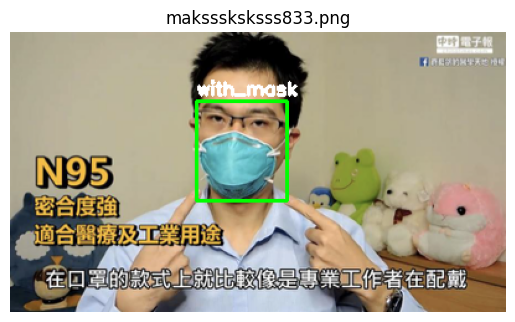

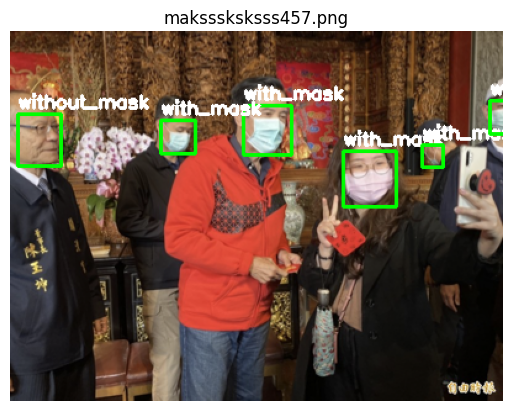

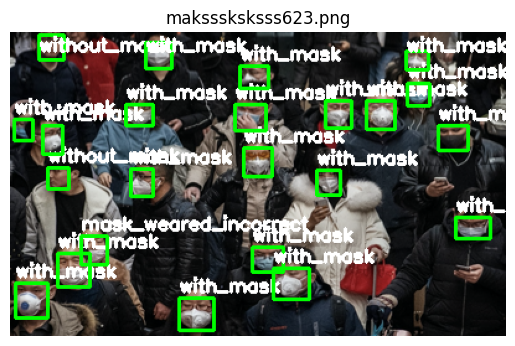

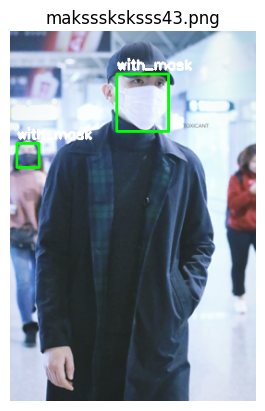

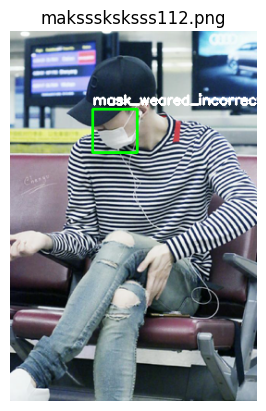

In [ ]:
# Visualisasi bounding box dari anotasi YOLO
def visualize_yolo_annotation(image_path, label_path, class_names):
    image = cv2.imread(str(image_path))
    height, width = image.shape[:2]

    if label_path.exists():
        for line in label_path.read_text().strip().splitlines():
            class_id, x_center, y_center, box_width, box_height = map(float, line.split())

            # Konversi koordinat relatif YOLO → piksel absolut
            x_center, y_center = x_center * width, y_center * height
            box_width, box_height = box_width * width, box_height * height

            x1, y1 = int(x_center - box_width / 2), int(y_center - box_height / 2)
            x2, y2 = int(x_center + box_width / 2), int(y_center + box_height / 2)

            cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(image, class_names[int(class_id)], (x1, max(15, y1 - 5)),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

    # Kembalikan citra dalam format RGB untuk matplotlib
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


# Tampilkan contoh hasil anotasi
sample_images = list((WORK / "train/images").glob("*.*"))[:5]
for image_path in sample_images:
    annotated_image = visualize_yolo_annotation(
        image_path,
        WORK / "train/labels" / f"{image_path.stem}.txt",
        CLASSES
    )
    plt.figure()
    plt.imshow(annotated_image)
    plt.axis("off")
    plt.title(image_path.name)
    plt.show()


## 6. Pelatihan Model (Model Training)

Ini adalah inti dari proyek kita. Kita tidak melatih model dari nol, melainkan menggunakan **Transfer Learning**.

Kita mengambil model `yolov8n.pt` yang sudah "pintar" (dilatih pada dataset besar bernama [COCO](https://cocodataset.org/#home)) dan melatihnya kembali (*fine-tuning*) secara spesifik untuk mengenali 3 kelas masker kita. Pendekatan ini jauh lebih cepat dan efisien.

Parameter utamanya adalah:
* **`MODEL = "yolov8n.pt"`**: Model nano, yang tercepat dan terkecil.
* **`EPOCHS = 30`**: Model akan mempelajari keseluruhan dataset latih sebanyak 30 kali.
* **`BATCH = 16`**: Memproses 16 gambar sekaligus.
* **`IMSZ = 640`**: Mengubah ukuran semua gambar menjadi 640x640 piksel.

Kita kemudian memanggil `model.train()` untuk memulai proses *fine-tuning* ini, yang akan menyimpan semua hasilnya di folder `WORK/runs/mask_yolov8n`.

In [ ]:
MODEL = "yolov8n.pt"
EPOCHS = 30
BATCH = 16
IMSZ = 640
DEVICE = 0 if torch.cuda.is_available() else "cpu"

In [ ]:
model = YOLO(MODEL)
train_res = model.train(
    data=str(WORK/"data.yaml"),
    epochs=EPOCHS,
    imgsz=IMSZ,
    batch=BATCH,
    device=DEVICE,
    workers=2,
    project=str(WORK/"runs"),
    name="mask_yolov8n",
    exist_ok=True
)

Ultralytics 8.3.227 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/mask-yolo/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=mask_yolov8n, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pos

Ini adalah ringkasan performa model setelah diuji menggunakan *validation set* (128 gambar).

Berikut penjelasan untuk setiap metrik:
* **`Class`**: Nama kelas yang diukur. `all` adalah rata-rata untuk semua kelas.
* **`Images`**: Jumlah gambar yang digunakan untuk pengujian (128).
* **`Instances`**: Jumlah total objek (masker) yang ada di 128 gambar tersebut (604).
* **`Box(P)` (Precision / Presisi)**: Dari semua deteksi yang dibuat model, persentase yang benar (`0.883` atau **88.3%**).
* **`R` (Recall / Jangkauan)**: Dari semua objek yang seharusnya ada di gambar, persentase yang berhasil ditemukan model (`0.747` atau **74.7%**).
* **`mAP50`**: Ini adalah **skor akurasi utama**. Angka `0.853` (atau **85.3%**) berarti model baik dalam mendeteksi objek, dengan syarat tumpang tindih (IoU) minimal 50%.
* **`mAP50-95`**: Ini adalah skor akurasi yang lebih ketat, mengukur rata-rata mAP pada berbagai ambang batas IoU (50% hingga 95%). Skor `0.592` (**59.2%**) menunjukkan model cukup presisi dalam menempatkan kotak deteksi.

---

**Kesimpulan**:

Secara keseluruhan, model memiliki **akurasi yang baik**, dengan skor **mAP50 sebesar 85.3%**.

Analisis per kelas:
* Model **sangat baik** mendeteksi `with_mask` (mAP50 95.5%).
* Model **baik** dalam mendeteksi `without_mask` (mAP50 87.7%).
* Model **cukup baik** mendeteksi `mask_weared_incorrect` (mAP50 72.8%). Performa ini wajar karena kelas ini memiliki data paling sedikit (imbalanced).

## 7. Validasi & Evaluasi Model

Setelah pelatihan selesai, model dievaluasi secara formal menggunakan **validation set**. Set data ini berisi gambar yang **tidak pernah** digunakan selama proses pelatihan.

### 7.1. Menjalankan Validasi

Validasi dijalankan dengan memanggil fungsi `model.val()`, yang diarahkan ke *split* `"val"` pada file `data.yaml`. Perintah ini mengeksekusi model pada seluruh gambar validasi untuk menghitung metrik performa.

Metrik utama yang digunakan adalah **mAP (mean Average Precision)**, yang merupakan standar untuk mengukur akurasi model deteksi objek.

* **`mAP50` (atau `mAP50(B)`)**: mAP yang dihitung pada ambang batas IoU (Intersection over Union) 0.50. Sebuah deteksi dianggap "benar" jika *bounding box* tumpang tindih **>50%** dengan *ground truth*. Ini adalah metrik yang paling umum digunakan.
* **`mAP50-95` (atau `mAP50-95(B)`)**: Metrik yang **lebih ketat**, yang menghitung mAP rata-rata pada 10 ambang batas IoU berbeda (dari 0.50 hingga 0.95). Nilai ini memberikan gambaran yang lebih baik mengenai **presisi** lokasi *bounding box*.

In [ ]:
# Evaluasi model pada data validasi
validation_result = model.val(
    data=str(WORK / "data.yaml"),
    split="val",
    imgsz=IMSZ,
    batch=BATCH,
    device=DEVICE
)

# Ambil metrik evaluasi dari hasil validasi
metrics = validation_result.results_dict
print("mAP50:", metrics.get("metrics/mAP50(B)"))
print("mAP50-95:", metrics.get("metrics/mAP50-95(B)"))

# Tampilkan visualisasi hasil validasi (grafik dan matriks konfusi)
run_directories = sorted((WORK / "runs/detect").glob("mask_yolov8n*"))
latest_run_dir = run_directories[-1] if run_directories else None

if latest_run_dir:
    for filename in ["results.png", "confusion_matrix.png", "PR_curve.png"]:
        image_path = latest_run_dir / filename
        if image_path.exists():
            display(Image(filename=str(image_path)))


Ultralytics 8.3.227 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1527.5±681.8 MB/s, size: 394.1 KB)
val: Scanning /content/mask-yolo/val/labels.cache... 128 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 128/128 260.5Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 8/8 1.8it/s 4.5s
                   all        128        604      0.886      0.744      0.853      0.592
          without_mask         47        116      0.887       0.75      0.876      0.585
             with_mask        116        468       0.92      0.904      0.954      0.686
 mask_weared_incorrect         13         20      0.852      0.577      0.728      0.503
Speed: 3.7ms preprocess, 11.5ms inference, 0.0ms loss, 3.1ms postprocess per image
Results saved to /content/runs/detect/val
mAP50: 0.8528

Hasil validasi model menunjukkan performa yang sangat baik.

* **Akurasi Utama (mAP50): 85.3%**
    Skor ini menunjukkan model sangat baik dalam mendeteksi objek dengan tumpang tindih (IoU) > 50%.

* **Akurasi Ketat (mAP50-95): 59.2%**
    Skor ini mengukur akurasi pada ambang batas IoU yang lebih ketat (50% hingga 95%), menunjukkan presisi kotak deteksi yang baik.

* **Performa per Kelas (mAP50)**:
    * `with_mask`: **95.4%** (Performa terbaik)
    * `without_mask`: **87.6%** (Sangat akurat)
    * `mask_weared_incorrect`: **72.8%** (Cukup baik). Performa lebih rendah ini wajar karena jumlah data yang tidak seimbang (*imbalanced data*).

* **Presisi (P) vs. Jangkauan (R)**:
    * `Precision` (P) total: **88.6%**. Menunjukkan 88.6% tebakan model benar (rendah *false positive*).
    * `Recall` (R) total: **74.4%**. Menunjukkan model berhasil menemukan 74.4% dari total objek (kadang terjadi *false negative*).

* **Kecepatan**:
    * Waktu inferensi (`inference`) sangat cepat, yaitu **16.6 milidetik** per gambar (setara ~60 FPS).

## 8. Visualisasi Hasil

Setelah YOLOv8 di train menggunakan data kita, dia akan secara otomatis menyimpan proses belajarnya dari awal hingga akhir di direktori `/content/runs/detect/val` (atau sejenisnya).

Direktori ini berisi gambar proses training dari awal hingga akhir dan hasil evaluasi model secara mandiri. Mari kita lihat isinya:

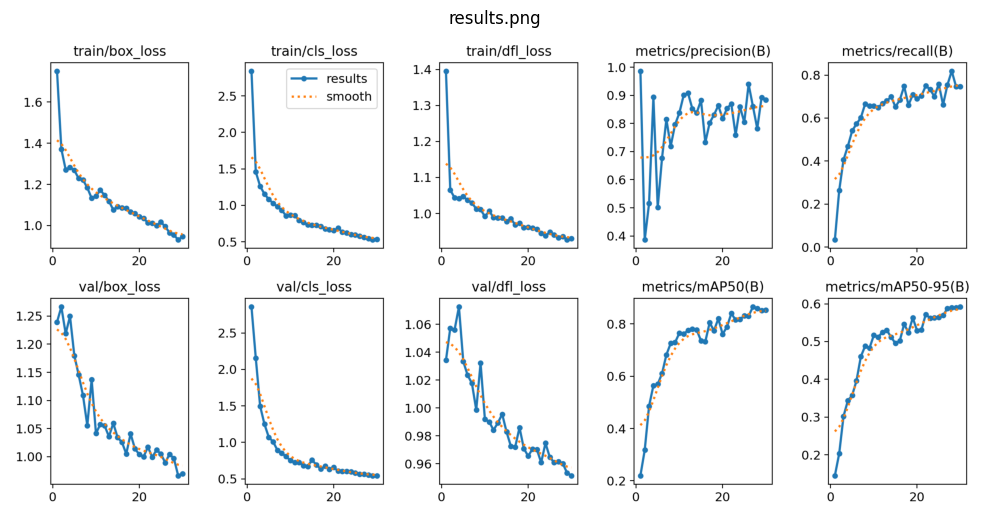

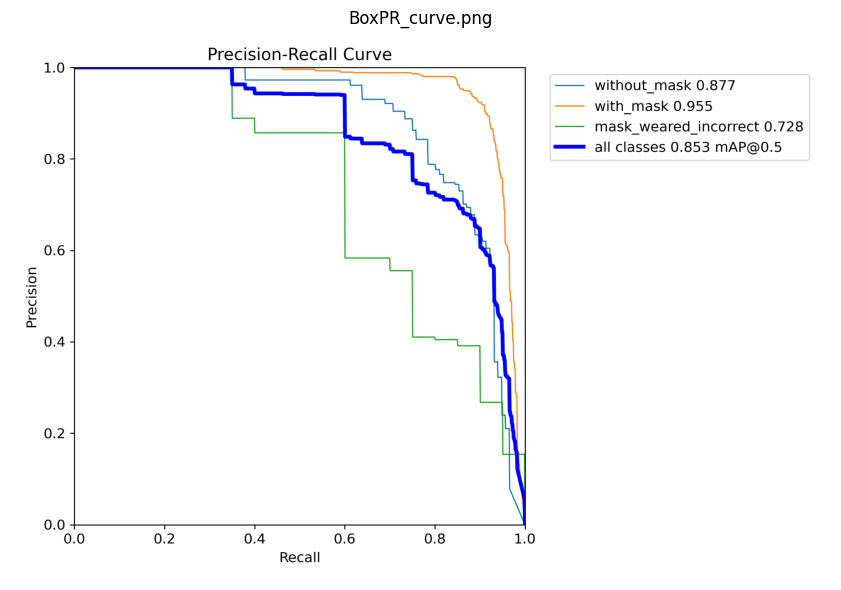

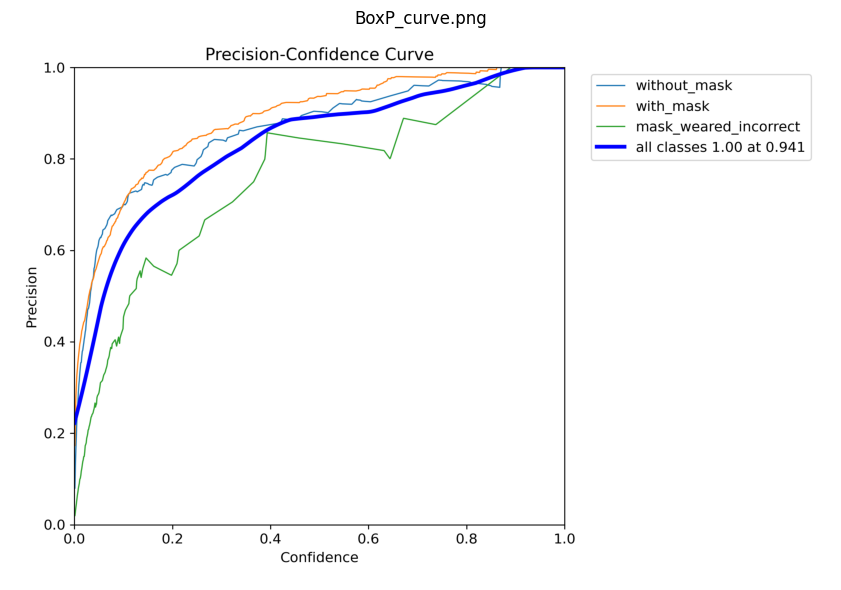

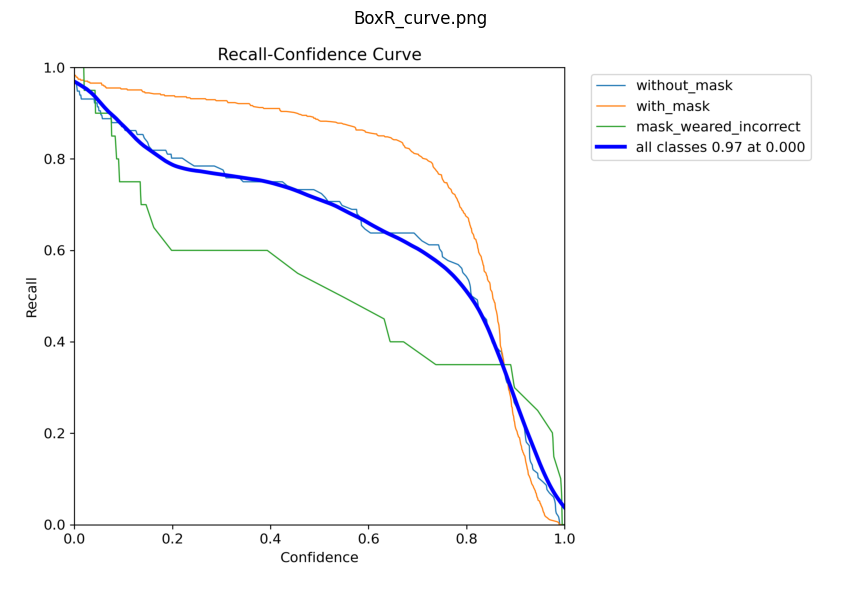

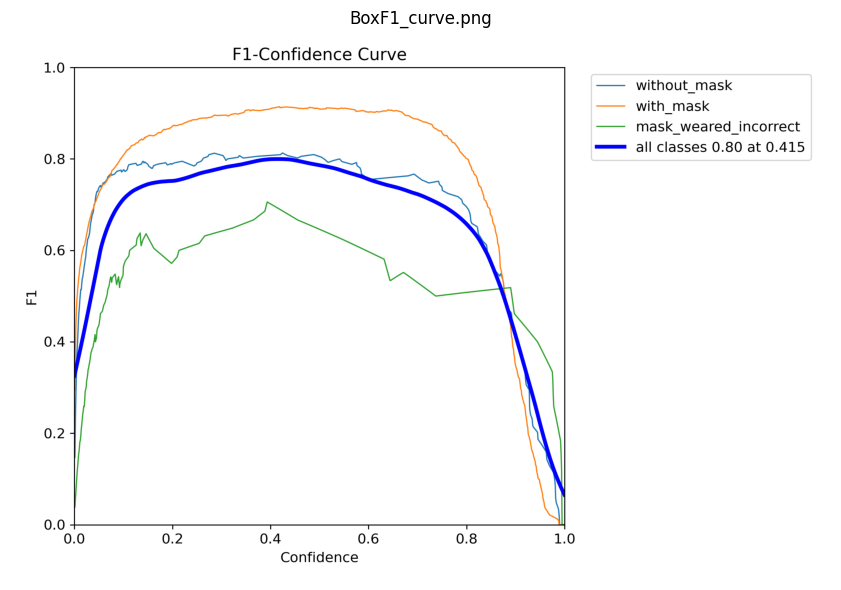

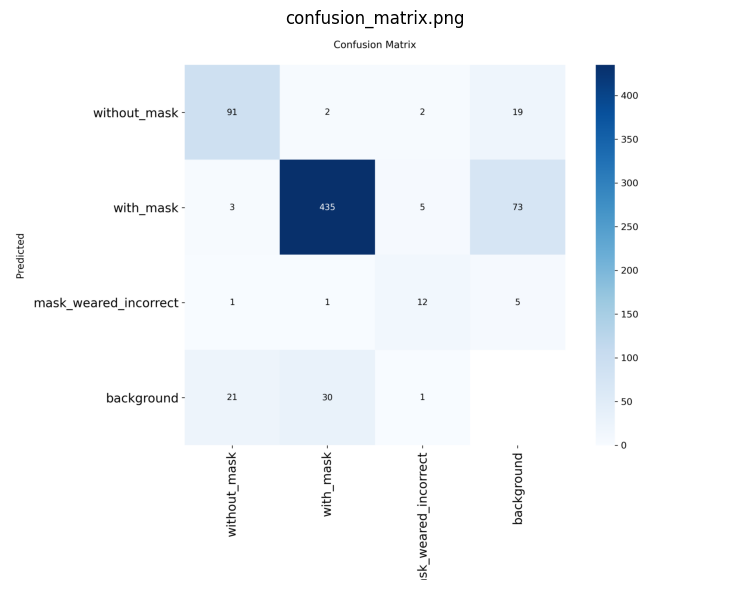

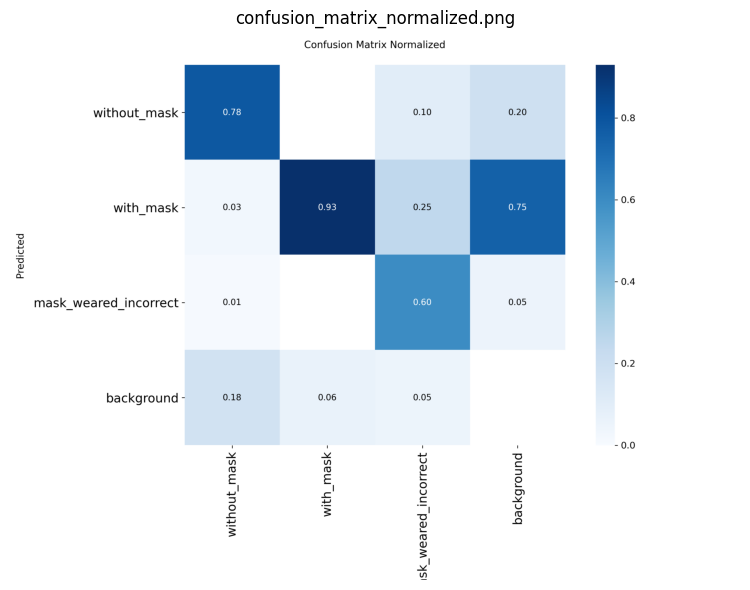

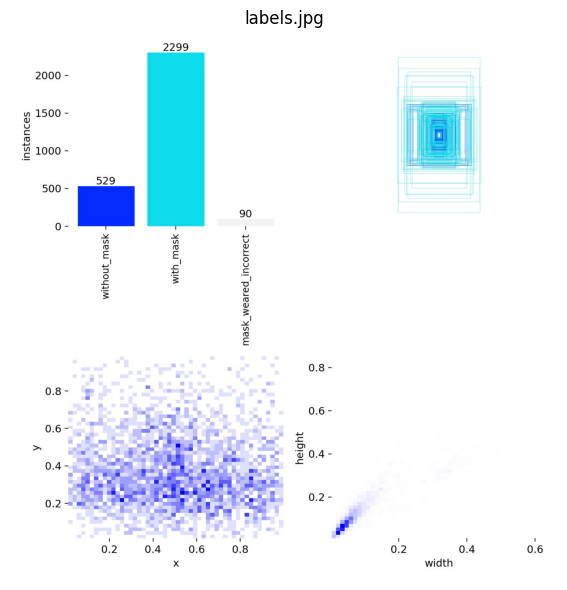

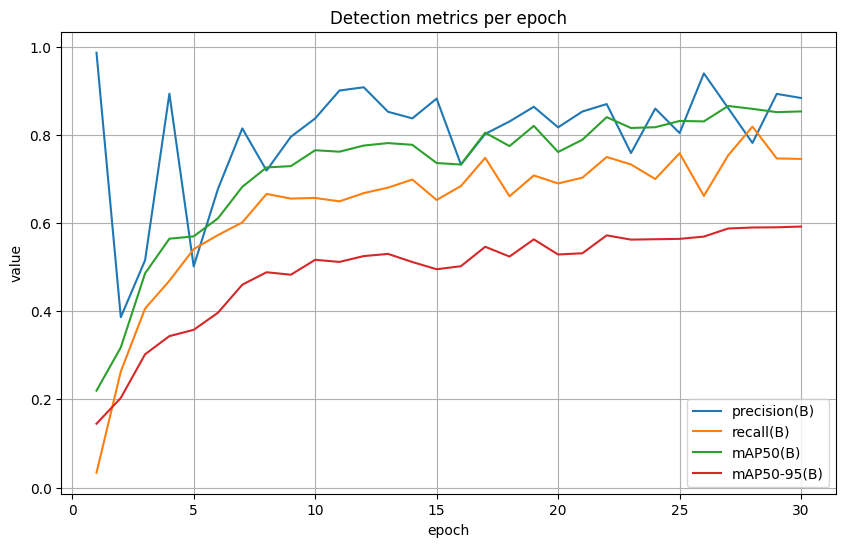

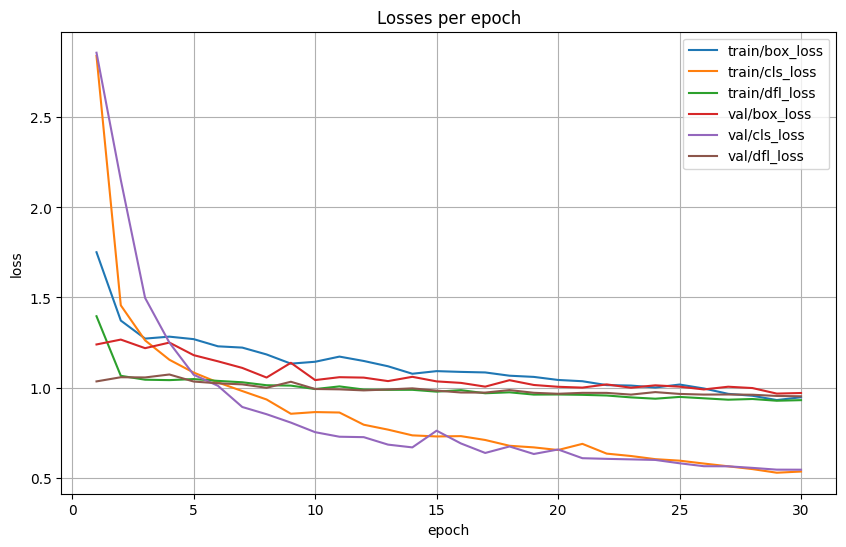

load.csv not found in run_dir


In [ ]:
run_dir = train_res.save_dir
image_order = [
    "results.png",
    "BoxPR_curve.png", "BoxP_curve.png", "BoxR_curve.png", "BoxF1_curve.png",
    "confusion_matrix.png", "confusion_matrix_normalized.png",
    "labels.jpg",
]

def show_img(path: Path, title: str):
    try:
        im = Image.open(path).convert("RGB")
        plt.figure(figsize=(10, 6))
        plt.imshow(im)
        plt.title(title)
        plt.axis("off")
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"skip {title}: {e}")

for name in image_order:
    p = run_dir / name
    if p.exists():
        show_img(p, name)

results_csv = run_dir / "results.csv"
if results_csv.exists():
    df = pd.read_csv(results_csv)
    df.columns = [c.strip() for c in df.columns]

    metric_cols = [
        "metrics/precision(B)",
        "metrics/recall(B)",
        "metrics/mAP50(B)",
        "metrics/mAP50-95(B)",
        "train/box_loss",
        "train/cls_loss",
        "train/dfl_loss",
        "val/box_loss",
        "val/cls_loss",
        "val/dfl_loss",
    ]
    epoch_col = "epoch" if "epoch" in df.columns else (df.columns[0] if len(df) else None)

    if epoch_col:
        quality = [c for c in metric_cols[:4] if c in df.columns]
        if quality:
            plt.figure(figsize=(10, 6))
            for c in quality:
                plt.plot(df[epoch_col], df[c], label=c.split("/")[-1])
            plt.xlabel("epoch")
            plt.ylabel("value")
            plt.title("Detection metrics per epoch")
            plt.grid(True)
            plt.legend()
            plt.show()

        losses = [c for c in metric_cols[4:] if c in df.columns]
        if losses:
            plt.figure(figsize=(10, 6))
            for c in losses:
                plt.plot(df[epoch_col], df[c], label=c)
            plt.xlabel("epoch")
            plt.ylabel("loss")
            plt.title("Losses per epoch")
            plt.grid(True)
            plt.legend()
            plt.show()
else:
    print("results.csv not found in run_dir")

load_csv = run_dir / "load.csv"
if load_csv.exists():
    dfl = pd.read_csv(load_csv)
    dfl.columns = [c.strip() for c in dfl.columns]
    numeric_cols = [c for c in dfl.columns if pd.api.types.is_numeric_dtype(dfl[c])]
    if numeric_cols:
        xkey = None
        for k in ["epoch", "step", "iter", "iteration", "batch"]:
            if k in dfl.columns and pd.api.types.is_numeric_dtype(dfl[k]):
                xkey = k
                break
        if xkey is None:
            xkey = numeric_cols[0]
        ykeys = [c for c in numeric_cols if c != xkey]
        for y in ykeys:
            plt.figure(figsize=(10, 4))
            plt.plot(dfl[xkey], dfl[y])
            plt.xlabel(xkey)
            plt.ylabel(y)
            plt.title(f"{y} over {xkey} (load.csv)")
            plt.grid(True)
            plt.show()
else:
    print("load.csv not found in run_dir")


Mari kita lihat beberapa hasil dari pelatihan YOLOv8 kita:

- **results.png**: Perhatikan bahwa plot *loss* (kesalahan) terus menurun. Ini artinya, seiring berjalannya waktu (epoch), model kita semakin jarang membuat tebakan yang salah. Sebaliknya, metrik seperti *precision* (presisi), *recall* (jangkauan), dan *mAP* (akurasi rata-rata) terus meningkat. Ini menunjukkan modelnya semakin pintar dan akurat dalam mendeteksi objek dengan benar.

- **confusion_matrix_normalized.png**: *Confusion matrix* (matriks kebingungan) adalah tabel yang merangkum performa model dalam mengenali setiap kelas.

    Lihat bahwa garis yang terbentuk pada matriks kita sangat kuat di bagian **diagonal** (dari kiri atas ke kanan bawah). Ini adalah hasil yang sangat baik. Ini mengartikan bahwa model kita sudah sangat bagus dalam memprediksi setiap kelas dengan benar (misalnya, menebak `with_mask` sebagai `with_mask`).

## 9. Inferensi Model

Ini adalah tahap yang ditunggu-tunggu! Setelah seluruh proses data preparation, model training, dan evaluasi model dijalankan, tahap akhir dari pembuatan model adalah inferensi model.

Inferensi adalah **proses menggunakan model yang sudah kita latih untuk membuat prediksi pada data (gambar) yang benar-benar baru**.

Cobalah untuk menjalankan sel kode dibawah ini dan masukkan gambarmu sendiri menggunakan masker atau gambar dari internet:

Saving mask_example_by_AI.png to mask_example_by_AI (1).png
User uploaded file "mask_example_by_AI (1).png" with length 473834 bytes

image 1/1 /content/mask-yolo/temp_inference_image.jpg: 448x640 1 without_mask, 3 with_masks, 38.8ms
Speed: 2.6ms preprocess, 38.8ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)
Results saved to /content/mask-yolo/runs/manual_inference

Inference Result:


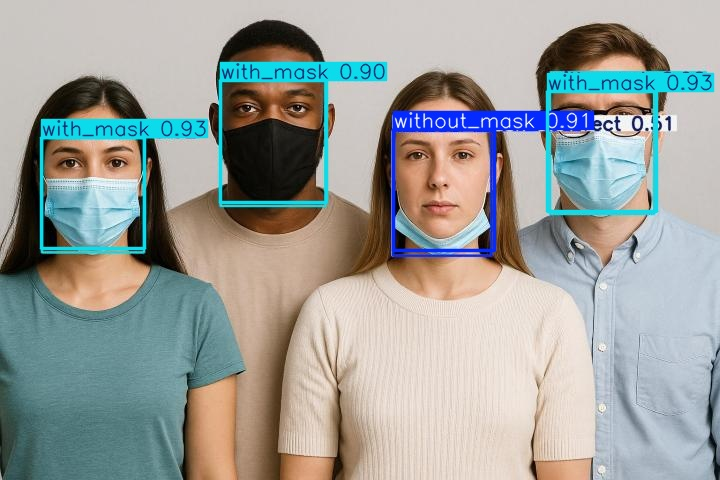

In [ ]:
uploaded = files.upload()
for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))

    img = Image.open(io.BytesIO(uploaded[fn]))

    temp_img_path = WORK / "temp_inference_image.jpg"
    img.save(temp_img_path)

    results = model.predict(
        source=str(temp_img_path),
        imgsz=IMSZ,
        device=DEVICE,
        save=True,
        save_txt=False,
        project=str(WORK/"runs"),
        name="manual_inference",
        exist_ok=True
    )

    if results and results[0].save_dir:
        predicted_img_path = Path(results[0].save_dir) / temp_img_path.name
        if predicted_img_path.exists():
            print("\nInference Result:")
            display(Image.open(predicted_img_path))
        else:
            print("Could not find the predicted image.")
    else:
        print("Inference failed.")

    if temp_img_path.exists():
        temp_img_path.unlink()